In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Streaming ASR with VAD

why asr with vad? TODO


This tutorials demonstrate how to integrate VAD to Streaming ASR. To reduce redundancy, this tutorial will not walk you through Streaming ASR step by step,  <b>please have a look at the detailed [Streaming ASR](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/asr/Streaming_ASR.ipynb) tutorial first.<b>

The pipeline of streaming ASR with VAD is as below. 
<!-- <img src="https://raw.githubusercontent.com/NVIDIA/NeMo/online_streaming_vad_asr/tutorials/asr/images/streaming_ASR_with_VAD.png" width="500"> -->

<img src="./images/streaming_ASR_with_VAD.png" width="700">

There are a few advantages of it:
1. NeMo VAD and ASR models are using same input feature, and the only difference is that we do not normalize it in VAD. We could use feature extractor for both modules.
2. When VAD detects begining and ending of speech, we will activate and deactivate feature normalizer and streaming ASR. This will introduce less latency and save computation resources as well as improve performance. 

This is for streaming VAD + ASR with CTC based models and you can easily adopt it to RNNT based models as well.

Note in NeMo we simulate this process by performing streaming VAD and generating speech segments first and perform streaming ASR inference on the segments. If you are interested in the inference pipeline and the interaction of each module, please refer to Riva. It will be in Riva soon.



We provide a script to help you perform streaming ASR with VAD inference, you can play with it. 

And we will walk you through it in this tutorial. 
1. TODO
2.

# script TODO 

# Prepare data and script for demonstration

In [2]:
input_manifest="chris_demo.json"

In [3]:
!head -n 10 $input_manifest

{"audio_filepath": "data/chris-sample01_02.wav", "duration": 123.7388125, "offset": 0,"text": "this is the first sample using a headset this is the second sample using a headset"}
{"audio_filepath": "data/chris-sample03.wav", "duration": 63.464, "offset": 0, "text": "this is the third sample using a laptop microphone"}

## Load VAD and ASR model

In [4]:
import torch
import nemo.collections.asr as nemo_asr
# import contextlib
# import gc

[NeMo W 2022-05-31 15:53:21 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# here we use stt_en_conformer_ctc_large as example
asr_model = nemo_asr.models.EncDecCTCModelBPE.from_pretrained("stt_en_conformer_ctc_large", map_location=device)
asr_model = asr_model.to(device)
VAD_MODEL="/home/fjia/models/mVAD_lin_marblenet-3x2x64-4N-256bs-50e-0.01lr-0.001wd/slurm_mVAD_lin_marblenet-3x2x64-4N-256bs-50e-0.01lr-0.001wd/checkpoints/mVAD_lin_marblenet-3x2x64-4N-256bs-50e-0.01lr-0.001wd.nemo"
# VAD_MODEL="/home/fjia/code/ngc_workspace/new_experiments/mul_vad/80_b256_lr0.02_min1e4_e50_3x4/80_b256_lr0.02_min1e4_e50_3x4/80_b256_lr0.02_min1e4_e50_3x4/2022-02-18_14-30-33/checkpoints/80_b256_lr0.02_min1e4_e50_3x4.nemo"
# /home/fjia/code/1007/b256_truelr0.02_min1e4_e200_2gpu/b256_truelr0.02_min1e4_e200_2gpu/b256_truelr0.02_min1e4_e200_2gpu/2021-10-06_17-43-59/checkpoints/b256_truelr0.02_min1e4_e200_2gpu--val_loss=0.0932-epoch=192.ckpt
vad_model = nemo_asr.models.EncDecClassificationModel.restore_from(VAD_MODEL,  map_location=device)
vad_model = vad_model.to(device)
asr_model.eval()
vad_model.eval()

[NeMo I 2022-05-31 15:53:22 cloud:56] Found existing object /home/fjia/.cache/torch/NeMo/NeMo_1.8.0rc0/stt_en_conformer_ctc_large/010120d9959425c7862c9843960b3235/stt_en_conformer_ctc_large.nemo.
[NeMo I 2022-05-31 15:53:22 cloud:62] Re-using file from: /home/fjia/.cache/torch/NeMo/NeMo_1.8.0rc0/stt_en_conformer_ctc_large/010120d9959425c7862c9843960b3235/stt_en_conformer_ctc_large.nemo
[NeMo I 2022-05-31 15:53:22 common:704] Instantiating model from pre-trained checkpoint
[NeMo I 2022-05-31 15:53:24 mixins:167] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2022-05-31 15:53:24 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/NeMo_ASR_SET/English/v2.0/train/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 32
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/NeMo_ASR_SET/English/v2.0/train/audio__OP_0..4095_CL_.tar
    
[NeMo W 2022-05-31 15:53:24 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /data/ASR/LibriSpeech/librispeech_withs

[NeMo I 2022-05-31 15:53:24 features:261] PADDING: 0
[NeMo I 2022-05-31 15:53:24 features:278] STFT using torch
[NeMo I 2022-05-31 15:53:27 save_restore_connector:157] Model EncDecCTCModelBPE was successfully restored from /home/fjia/.cache/torch/NeMo/NeMo_1.8.0rc0/stt_en_conformer_ctc_large/010120d9959425c7862c9843960b3235/stt_en_conformer_ctc_large.nemo.


[NeMo W 2022-05-31 15:53:27 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2022-05-31 15:53:27 features:261] PADDING: 16
[NeMo I 2022-05-31 15:53:27 features:278] STFT using torch
[NeMo I 2022-05-31 15:53:27 save_restore_connector:157] Model EncDecClassificationModel was successfully restored from /home/fjia/models/mVAD_lin_marblenet-3x2x64-4N-256bs-50e-0.01lr-0.001wd/slurm_mVAD_lin_marblenet-3x2x64-4N-256bs-50e-0.01lr-0.001wd/checkpoints/mVAD_lin_marblenet-3x2x64-4N-256bs-50e-0.01lr-0.001wd.nemo.


EncDecClassificationModel(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConvASREncoder(
    (encoder): Sequential(
      (0): JasperBlock(
        (mconv): ModuleList(
          (0): MaskedConv1d(
            (conv): Conv1d(80, 80, kernel_size=(11,), stride=(1,), padding=(5,), groups=80, bias=False)
          )
          (1): MaskedConv1d(
            (conv): Conv1d(80, 128, kernel_size=(1,), stride=(1,), bias=False)
          )
          (2): BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (mout): Sequential(
          (0): ReLU(inplace=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (1): JasperBlock(
        (mconv): ModuleList(
          (0): MaskedConv1d(
            (conv): Conv1d(128, 128, kernel_size=(13,), stride=(1,), padding=(6,), groups=128, bias=False)
          )
          (1): MaskedConv1d(
            (conv): Conv1d(128, 64, kernel

In [6]:
import copy
from omegaconf import OmegaConf
cfg = copy.deepcopy(asr_model._cfg)
OmegaConf.set_struct(cfg.preprocessor, False)
cfg.preprocessor.dither = 0.0
cfg.preprocessor.pad_to = 0

if cfg.preprocessor.normalize != "per_feature":
    logging.error("Only EncDecCTCModelBPE models trained with per_feature normalization are supported currently")
OmegaConf.set_struct(cfg.preprocessor, True)

Similar to AudioChunkIterator which return successive chunks of samples in Streaming ASR tutorial, 
here we use FeatureFrameBufferer return return an array of feature buffers. As noted above, VAD and ASR will use share it and and the only difference is <code>normalize_feature</code>

In [7]:
from nemo.collections.asr.parts.utils.streaming_utils import AudioBuffersDataLayer, speech_collate_fn
from torch.utils.data import DataLoader

In [8]:
class FeatureFrameBufferer:
    """
    Class to append each feature frame to a buffer and return
    an array of buffers.
    """

    def __init__(self, asr_model, frame_len=1.6, batch_size=4, total_buffer=4.0, normalize_feature=True):
        '''
        Args:
          frame_len: frame's duration, seconds
          frame_overlap: duration of overlaps before and after current frame, seconds
          offset: number of symbols to drop for smooth streaming
        '''
        self.normalize_feature = normalize_feature 
        self.ZERO_LEVEL_SPEC_DB_VAL = -16.635  # Log-Melspectrogram value for zero signal
        self.asr_model = asr_model
        self.sr = asr_model._cfg.sample_rate
        self.frame_len = frame_len
        timestep_duration = asr_model._cfg.preprocessor.window_stride
        self.n_frame_len = int(frame_len / timestep_duration)

        total_buffer_len = int(total_buffer / timestep_duration)
        self.n_feat = asr_model._cfg.preprocessor.features
        self.buffer = np.ones([self.n_feat, total_buffer_len], dtype=np.float32) * self.ZERO_LEVEL_SPEC_DB_VAL

        self.batch_size = batch_size

        self.signal_end = False
        self.frame_reader = None
        self.feature_buffer_len = total_buffer_len

        self.feature_buffer = (
            np.ones([self.n_feat, self.feature_buffer_len], dtype=np.float32) * self.ZERO_LEVEL_SPEC_DB_VAL
        )
        self.frame_buffers = []
        self.buffered_features_size = 0
        self.reset()
        self.buffered_len = 0

    def reset(self):
        '''
        Reset frame_history and decoder's state
        '''
        self.buffer = np.ones(shape=self.buffer.shape, dtype=np.float32) * self.ZERO_LEVEL_SPEC_DB_VAL
        self.prev_char = ''
        self.unmerged = []
        self.frame_buffers = []
        self.buffered_len = 0
        self.feature_buffer = (
            np.ones([self.n_feat, self.feature_buffer_len], dtype=np.float32) * self.ZERO_LEVEL_SPEC_DB_VAL
        )

    def get_batch_frames(self):
        if self.signal_end:
            return []
        batch_frames = []
        for frame in self.frame_reader:
            batch_frames.append(np.copy(frame))
            if len(batch_frames) == self.batch_size:
                return batch_frames
        self.signal_end = True

        return batch_frames

    def get_frame_buffers(self, frames):
        # Build buffers for each frame
        self.frame_buffers = []
        for frame in frames:
            self.buffer[:, : -self.n_frame_len] = self.buffer[:, self.n_frame_len :]
            self.buffer[:, -self.n_frame_len :] = frame
            self.buffered_len += frame.shape[1]
            
            self.frame_buffers.append(np.copy(self.buffer))
        return self.frame_buffers

    def set_frame_reader(self, frame_reader):
        self.frame_reader = frame_reader
        self.signal_end = False

    def _update_feature_buffer(self, feat_frame):
        self.feature_buffer[:, : -feat_frame.shape[1]] = self.feature_buffer[:, feat_frame.shape[1] :]
        self.feature_buffer[:, -feat_frame.shape[1] :] = feat_frame
        self.buffered_features_size += feat_frame.shape[1]

    def get_norm_consts_per_frame(self, batch_frames):
        norm_consts = []
        for i, frame in enumerate(batch_frames):
            self._update_feature_buffer(frame)
            mean_from_buffer = np.mean(self.feature_buffer, axis=1)
            stdev_from_buffer = np.std(self.feature_buffer, axis=1)
            norm_consts.append((mean_from_buffer.reshape(self.n_feat, 1), stdev_from_buffer.reshape(self.n_feat, 1)))
        return norm_consts

    def normalize_frame_buffers(self, frame_buffers, norm_consts):
        CONSTANT = 1e-5
        for i, frame_buffer in enumerate(frame_buffers):
            frame_buffers[i] = (frame_buffer - norm_consts[i][0]) / (norm_consts[i][1] + CONSTANT)

    def get_buffers_batch(self):
        batch_frames = self.get_batch_frames()

        while len(batch_frames) > 0:

            frame_buffers = self.get_frame_buffers(batch_frames)
            norm_consts = self.get_norm_consts_per_frame(batch_frames)
            if len(frame_buffers) == 0:
                continue
            if self.normalize_feature:
                norm_consts = self.get_norm_consts_per_frame(batch_frames)
                self.normalize_frame_buffers(frame_buffers, norm_consts)
            return frame_buffers
        return []
    
    

Similar to <code>ChunkBufferDecoder</code> in streaming ASR tutorial, we have 

- class <code>FrameBatchASR</code> for streaming frame-based ASR and 
- class <code>FrameBatchVAD</code> for streaming frame-based VAD.
Since FrameBatchASR has been introduced in streaming ASR, we ignore it in this tutorial, please refer to streaming_utils.py for more information, 

In [9]:
from nemo.collections.asr.parts.utils.streaming_utils import FrameBatchASR

Let's walk through FrameBatchVAD

In [10]:
from nemo.collections.asr.parts.utils.streaming_utils import get_samples, AudioFeatureIterator
class FrameBatchVAD:
    """
    class for streaming frame-based ASR use reset() method to reset FrameASR's
    state call transcribe(frame) to do ASR on contiguous signal's frames
    """

    def __init__(
        self, vad_model, frame_len=0.16, total_buffer=0.63, batch_size=4, patience=25, total_asr_buffer=4,
    ):
        '''
        Args:
          frame_len: frame's duration, seconds
          frame_overlap: duration of overlaps before and after current frame, seconds
          offset: number of symbols to drop for smooth streaming
        '''
        # Note the feature sent into VAD is none normalized
        self.frame_bufferer = FeatureFrameBufferer(
            asr_model=vad_model, frame_len=frame_len, batch_size=batch_size, total_buffer=total_buffer, 
            normalize_feature=False 
        )
        self.patience=patience
        self.vad_model = vad_model

        self.batch_size = batch_size
        self.all_vad_preds = []
        self.vad_decision_buffer = [0] * (self.patience+1)
        self.speech_segment = set()
        self.start = 0
        self.end=0
        self.is_speech = False
       
        # new
        self.mask_len = int(total_asr_buffer/frame_len)
        self.mask = [0] * self.mask_len

        self.frame_buffers = []
        self.reset()
        cfg = copy.deepcopy(vad_model._cfg)
        self.frame_len = frame_len
        OmegaConf.set_struct(cfg.preprocessor, False)

        # some changes for streaming scenario
        cfg.preprocessor.dither = 0.0
        cfg.preprocessor.pad_to = 0
        cfg.preprocessor.normalize = "None"
        self.raw_preprocessor = EncDecClassificationModel.from_config_dict(cfg.preprocessor)
        self.raw_preprocessor.to(vad_model.device)

    def reset(self):
        """
        Reset frame_history and decoder's state
        """
        self.data_layer = AudioBuffersDataLayer()
        self.data_loader = DataLoader(self.data_layer, batch_size=self.batch_size, collate_fn=speech_collate_fn)

        self.all_vad_preds = []
        self.vad_decision_buffer = [0] * (self.patience+1)
        self.speech_segment = set()
        self.start = 0
        self.end=0
        self.is_speech = False
        self.frame_bufferer.reset()
        
        #new 
        self.mask = [0] * self.mask_len

    def read_audio_file(self, 
                        audio_filepath: str, 
                        offset: float,
                        duration: float,
                        delay: float, 
                        model_stride_in_secs: float):
        samples = get_samples(audio_filepath, offset, duration)
        self.pad_end_len = int(delay * model_stride_in_secs * self.vad_model._cfg.sample_rate)
        samples = np.pad(samples, (0, self.pad_end_len))
        frame_reader = AudioFeatureIterator(samples, self.frame_len, self.raw_preprocessor, self.vad_model.device)
        self.set_frame_reader(frame_reader)

    def set_frame_reader(self, frame_reader):
        self.frame_bufferer.set_frame_reader(frame_reader)

    def online_decision(self, current_pred, current_frame, end_of_seq=False, threshold=0.4):
         # binarization
        if current_pred >= threshold:
            current_decision = 1
        else:
            current_decision = 0
        
        # change happens
        if not self.is_speech and self.vad_decision_buffer.count(1) > 2:
            self.is_speech = True
            self.start = current_frame  
            
        if self.is_speech and self.vad_decision_buffer.count(1) == 0:
            self.is_speech = False
            self.end = current_frame
            self.speech_segment.add((round(self.start,2) , round(self.end, 2)))
            
        if self.is_speech and end_of_seq:
            self.end = current_frame 
            self.speech_segment.add((self.start, self.end))

        self.vad_decision_buffer = self.vad_decision_buffer[1:]
        self.vad_decision_buffer.append(current_decision)
        print("decision buffer:", self.vad_decision_buffer)
        
        # new
        self.mask = self.mask[1:]
        self.mask.append(current_decision)
        print("mask buffer:", self.mask)
        
      
    @torch.no_grad()
    def infer_logits(self):
        frame_buffers = self.frame_bufferer.get_buffers_batch()

        while len(frame_buffers) > 0:
            self.frame_buffers += frame_buffers[:]
            self.data_layer.set_signal(frame_buffers[:])
            self._get_batch_preds()
            frame_buffers = self.frame_bufferer.get_buffers_batch()

    @torch.no_grad()
    def _get_batch_preds(self):
        device = self.vad_model.device
        for batch in iter(self.data_loader):

            feat_signal, feat_signal_len = batch
            feat_signal, feat_signal_len = feat_signal.to(device), feat_signal_len.to(device)

            logits = self.vad_model(
                processed_signal=feat_signal, 
                processed_signal_length=feat_signal_len
            )
                
            vad_probs = torch.softmax(logits, dim=-1)
            vad_pred = vad_probs[:, 1]
            vad_pred = vad_pred.cpu().numpy()
            self.all_vad_preds.extend(vad_pred)

            del logits

    def decode(self, threshold=0.4):
        self.infer_logits()
        end_of_seq = False
        for i in range(len(self.all_vad_preds)):
            current_pred = self.all_vad_preds[i]
            current_frame = i * self.frame_len
            
            if i == len(self.all_vad_preds)-1 :
                end_of_seq = True

#             print(current_pred, current_frame)
            self.online_decision(current_pred, current_frame, end_of_seq, threshold)

            if end_of_seq:
                break
            
        return self.all_vad_preds, self.speech_segment

We introduce `online_decision` in `decode` function. Basically we binarize the VAD output of current frame with `threshold` and append to `vad_decision_buffer` of length (patience+1). 

The online_decision method here is quite simple and we would recommend to use a more sophiscated method that might improve performance.



In [11]:
# asr
chunk_len_in_ms = 160
total_buffer_in_secs = 4
model_stride = 4 # 8 for citrinet
# vad
total_vad_buffer_in_secs = 0.63

In [12]:
import numpy as np

In [13]:
import math
feature_stride = cfg.preprocessor['window_stride']
model_stride_in_secs = feature_stride * model_stride
total_buffer = total_buffer_in_secs
chunk_len = chunk_len_in_ms / 1000
batch_size = 128
tokens_per_chunk = math.ceil(chunk_len / model_stride_in_secs)
mid_delay = math.ceil((chunk_len + (total_buffer - chunk_len) / 2) / model_stride_in_secs)

total_vad_buffer = total_vad_buffer_in_secs
vad_mid_delay = math.ceil((chunk_len + (total_vad_buffer - chunk_len) / 2) / 1)
        

In [14]:
from nemo.collections.asr.models.ctc_bpe_models import EncDecCTCModelBPE
from nemo.collections.asr.models.classification_models import EncDecClassificationModel

In [15]:
frame_vad = FrameBatchVAD(
    vad_model=vad_model, frame_len=chunk_len, total_buffer=total_vad_buffer, batch_size=batch_size, patience=9
)

[NeMo I 2022-05-31 15:53:28 features:261] PADDING: 0
[NeMo I 2022-05-31 15:53:28 features:278] STFT using torch


In [16]:
frame_asr = FrameBatchASR(
    asr_model=asr_model, frame_len=chunk_len, total_buffer=total_buffer, batch_size=batch_size,
)

[NeMo I 2022-05-31 15:53:28 features:261] PADDING: 0
[NeMo I 2022-05-31 15:53:28 features:278] STFT using torch


In [17]:
import json
def get_wer_feat(mfst, asr, frame_len, tokens_per_chunk, delay, preprocessor_cfg, model_stride_in_secs, device,vad=None, vad_delay=None,threshold: float = 0.4,
    look_back: int = 4):
    # Create a preprocessor to convert audio samples into raw features,
    # Normalization will be done per buffer in frame_bufferer
    # Do not normalize whatever the model's preprocessor setting is
    preprocessor_cfg.normalize = "None"
    preprocessor = nemo_asr.models.EncDecCTCModelBPE.from_config_dict(preprocessor_cfg)
    preprocessor.to(device)
    hyps = []
    refs = []
    total_durations_to_asr = []
    original_durations = []
    total_speech_segments = []
    total_streaming_vad_logits = []

    with open(mfst, "r") as mfst_f:
        for l in mfst_f:
            asr.reset()
            row = json.loads(l.strip())
            if vad:
                vad.reset()
                vad.read_audio_file(row['audio_filepath'], offset=0, duration=0, delay=vad_delay, model_stride_in_secs=1)          
                streaming_vad_logits, speech_segments = vad.decode(threshold=threshold)
                speech_segments = [list(i) for i in speech_segments]
                speech_segments.sort(key=lambda x: x[0])

                final_hyp = " "
                total_duration_to_asr = 0
                for i in range(len(speech_segments)): 
                    asr.reset()
                    offset = max(speech_segments[i][0] - frame_len * look_back, 0)

                    if row['duration'] and speech_segments[i][1] > row['duration']:
                        end = row['duration']
                        speech_segments[i][1] = end
                    else:
                        end = speech_segments[i][1]
                    
                    duration = end - speech_segments[i][0] + frame_len * look_back
                    
                    asr.read_audio_file(row['audio_filepath'], offset, duration, delay, model_stride_in_secs)
                    hyp = asr.transcribe(tokens_per_chunk, delay) + " "
                    # there should be some better method to merge the hyps of segments.
                    final_hyp += hyp
                    total_duration_to_asr += duration

                final_hyp = final_hyp[1:-1]
                # final_hyp = clean_label(final_hyp, num_to_words)
                # ref_clean = clean_label(row['text'], num_to_words)

                hyps.append(final_hyp)
                refs.append(row['text'])
                total_durations_to_asr.append(total_duration_to_asr)
                original_durations.append(row['duration'])
                total_speech_segments.append(speech_segments)
                total_streaming_vad_logits.append(streaming_vad_logits)

            else:
                asr.read_audio_file(row['audio_filepath'], offset=0, duration=0, delay=delay, model_stride_in_secs=model_stride_in_secs)
                hyp = asr.transcribe(tokens_per_chunk, delay)
                hyps.append(hyp)
                refs.append(row['text'])

                total_durations_to_asr.append(row['duration'])
                speech_segments = "ALL"
                total_speech_segments.append(speech_segments)

    wer = word_error_rate(hypotheses=hyps, references=refs)
    print(f"Overall word error rate is {wer}")
    if vad:
        print(f"VAD reduces total durations for ASR inference from {int(sum(original_durations))} seconds to {int(sum(total_durations_to_asr))} seconds, by filtering out some noise or music")
    
    return hyps, refs, wer, total_durations_to_asr, total_speech_segments, total_streaming_vad_logits



In [18]:
threshold = 0.8
look_back=4

In [19]:
from nemo.collections.asr.metrics.wer import word_error_rate

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

In [21]:
hyps, refs, wer, total_durations_to_asr, total_speech_segments, total_streaming_vad_logits = get_wer_feat(
    input_manifest,
    frame_asr,
    chunk_len,
    tokens_per_chunk,
    mid_delay,
    cfg.preprocessor,
    model_stride_in_secs,
    asr_model.device,
    frame_vad,
    vad_mid_delay,
    threshold,
    look_back, 
)

[NeMo I 2022-05-31 15:53:28 features:261] PADDING: 0
[NeMo I 2022-05-31 15:53:28 features:278] STFT using torch
decision buffer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mask buffer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
decision buffer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mask buffer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
decision buffer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mask buffer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
decision buffer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mask buffer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
decision buffer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
mask buffer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
decision buffer: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
mask buffer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
decision buffer: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
mask buffer: [0, 0

script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.shape (80, 400)
script self.buffer.s

Overall word error rate is 0.0
VAD reduces total durations for ASR inference from 187 seconds to 14 seconds, by filtering out some noise or music


In [22]:
total_speech_segments

[[[1.12, 4.96], [64.8, 68.8]], [[1.44, 5.92]]]

In [23]:
output_path = "output" # the path of output folder

In [24]:
import os

In [25]:
fname = "streaming_demo_output.json"
hyp_json = os.path.join(output_path, fname)
os.makedirs(output_path, exist_ok=True)
os.makedirs("vad_logits", exist_ok=True)
with open(hyp_json, "w") as out_f:
    for i, hyp in enumerate(hyps):
        vad_output_file = os.path.join("vad_logits", str(i) + ".npy")
        np.save(vad_output_file, total_streaming_vad_logits[i])
        record = {
            "pred_text": hyp,
            "text": refs[i],
            "wer": round(word_error_rate(hypotheses=[hyp], references=[refs[i]]) * 100, 2),
            "total_duration_to_asr": total_durations_to_asr[i],
            "total_speech_segments": total_speech_segments[i],
            "total_streaming_vad_logits": vad_output_file,
        }
        out_f.write(json.dumps(record) + '\n')

In [26]:
data = []
with open(hyp_json, "r") as fp:
    for line in fp:
        data.append(json.loads(line))

In [27]:
input_data = []
with open(input_manifest, "r") as fp:
    for line in fp:
        input_data.append(json.loads(line))

In [28]:
import librosa
import IPython.display as ipd

In [29]:
i = 1
audio_filepath = input_data[i]['audio_filepath']
print(f"orginal duration is of {audio_filepath} is {input_data[i]['duration']}")

for speech_segment in data[i]['total_speech_segments']: 
    print("Speech Segment:", speech_segment)
    offset = max(speech_segment[0] - chunk_len * look_back, 0)
    duration = speech_segment[1] - speech_segment[0] + chunk_len * look_back
    
    audio_snipt, sample_rate = librosa.load(audio_filepath, offset=offset, duration=duration, sr=16000)
    total_streaming_vad_logits = np.load(data[i]['total_streaming_vad_logits'])
    ipd.display(ipd.Audio(audio_snipt, rate=sample_rate))

orginal duration is of data/chris-sample03.wav is 63.464
Speech Segment: [1.44, 5.92]


In [30]:
audio, sample_rate = librosa.load(audio_filepath, sr=16000)

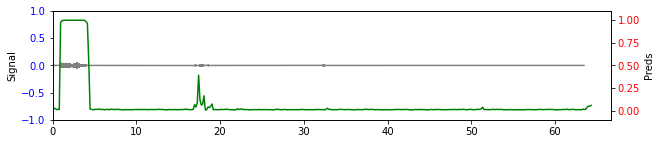

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 2])
ax1 = plt.subplot()
ax1.plot(np.arange(len(audio))/16000, audio, 'gray')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylabel('Signal')
ax1.set_ylim([-1, 1])
ax1.set_xlim(0, )
ax2 = ax1.twinx()
ax2.plot(np.arange(len(total_streaming_vad_logits))*chunk_len , total_streaming_vad_logits, 'g')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Preds')
ax2.set_ylim([-0.1, 1.1])
plt.show()